In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

# Informe Técnico de Minería de Datos: Análisis del Clima en Australia

Este notebook se organiza en base a las dos primeras fases de la metodología CRISP-DM: **Business Understanding** y **Data Understanding**. Además, se introduce la idea de construir un “Índice de Riesgo Climático por ciudad” que responda a la pregunta: “¿Qué regiones de Australia tienen más riesgo de fenómenos extremos?” mediante un score que combine:

- **Velocidad de Ráfaga (WindGustSpeed)**
- **Máxima Temperatura (MaxTemp)**
- **Baja Humedad**
- **Alta Precipitación (Rainfall)**

El índice se escalara y presentará por ubicación, generando un ranking de ciudades “más extremas climáticamente” y, para una temporada o fecha específica, se indicarán cuáles son las ciudades con mayor riesgo y qué factores son los determinantes.

---

## 1. Business Understanding

### 1.1. Introducción

El objetivo de este análisis es sentar las bases para el desarrollo de modelos predictivos y la construcción de un índice de riesgo climático. Este índice ayudará a identificar las regiones de Australia con mayor riesgo de fenómenos extremos, lo que es fundamental para la toma de decisiones estratégicas en áreas como la agricultura, el turismo y la gestión de riesgos.

### 1.2. Objetivos del Negocio y KPIs

- **Objetivos del Negocio:**
  - Mejorar la capacidad predictiva del clima mediante modelos que anticipen condiciones adversas.
  - Optimizar recursos y planificaciones basadas en condiciones climáticas específicas.
  - Reducir riesgos al identificar regiones vulnerables a fenómenos extremos.

- **KPIs Relevantes:**
  - Número de días con precipitaciones intensas.
  - Promedio y variabilidad de temperaturas (MinTemp y MaxTemp).
  - Frecuencia de eventos extremos (outliers en Rainfall y RISK_MM).
  - Índices de humedad y presión que ayuden a identificar cambios bruscos en el clima.

## 2. Data Understanding

### 2.1. Carga y Visualización de Datos

In [4]:
df = pd.read_csv('weatherAUS.csv')

In [5]:
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_

In [6]:
print("\nEstadísticas descriptivas:")
print(df.describe())


Estadísticas descriptivas:
             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000

In [7]:
# Valores faltantes por columna
print("\nValores perdidos por columna:")
print(df.isnull().sum())

# Verificar registros duplicados
print("\nFilas duplicadas:")
print(df.duplicated().sum())


Valores perdidos por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

Filas duplicadas:
0


[03/25/25 17:33:23] WARNING  /usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: ]8;id=542877;file:///usr/local/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=336285;file:///usr/local/lib/python3.10/warnings.py#109\109]8;;\
                             DeprecationWarning: backend2gui is deprecated since IPython 8.24,                     
                             backends are managed in matplotlib and can be externally registered.                  
                               warnings.warn(                                                                      
                                                                                                                   

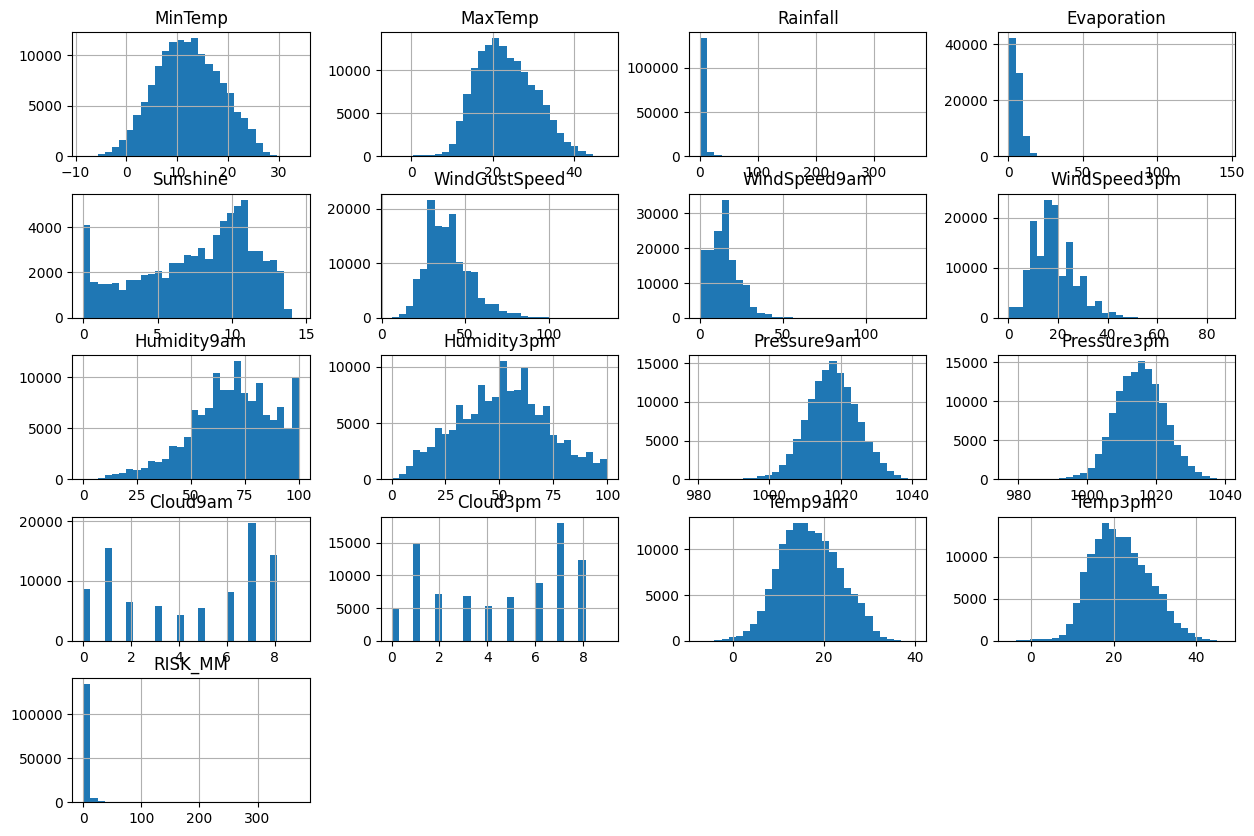

In [8]:
# Histogramas para ver la distribución de variables numéricas
df.hist(bins=30, figsize=(15,10))
plt.show()

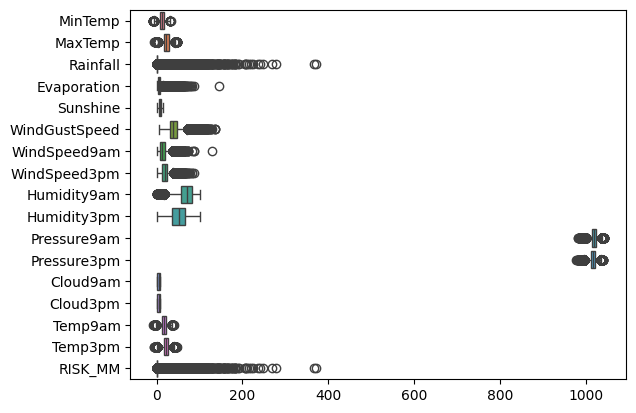

In [9]:
# Boxplot para detectar outliers en variables numéricas
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient="h")
plt.show()

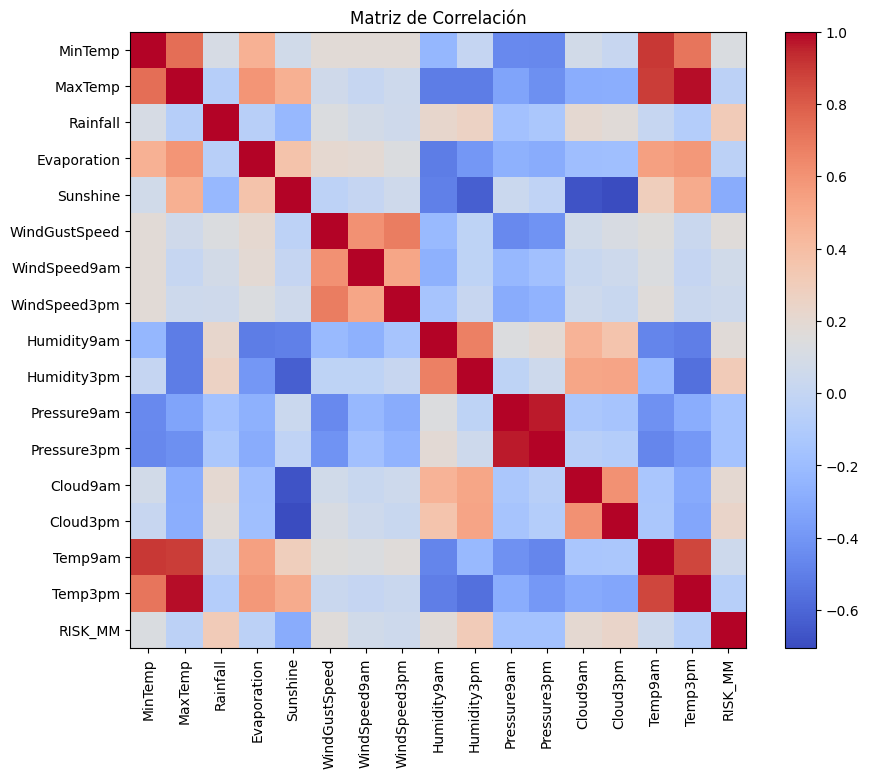

In [10]:
# Seleccionar columnas numéricas y calcular la matriz de correlación
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de Correlación")
plt.show()

# 1. Conclusiones a partir de los resultados

A partir de los histogramas, boxplots, matriz de correlación y estadísticas descriptivas, se pueden extraer varios insights:

1. **Distribución de las variables (Histogramas):**  
   - Algunas variables (por ejemplo, *Rainfall* y *RISK_MM*) presentan distribuciones muy asimétricas, con la mayoría de valores en rangos bajos y unos pocos extremadamente altos.  
   - *MinTemp* y *MaxTemp* parecen más cercanas a distribuciones normales, aunque muestran colas que indican días inusualmente fríos o cálidos.

2. **Outliers identificados (Boxplots):**  
   - Existen valores atípicos en *Rainfall*, *Evaporation* y *RISK_MM*. Podrían corresponder a fenómenos climáticos extremos o a errores de medición.  
   - Estos outliers pueden distorsionar análisis estadísticos, por lo que conviene confirmar su veracidad.

3. **Matriz de Correlación:**  
   - Se aprecia una correlación positiva notable entre *MinTemp* y *MaxTemp*.  
   - Variables como *Sunshine* y *Cloud9am/Cloud3pm* suelen relacionarse de forma inversa, aunque esto se ve limitado por la cantidad de valores faltantes.  
   - Este análisis de correlación es útil para la selección de variables relevantes en futuros modelos o índices.

4. **Valores Faltantes y Duplicados:**  
   - Hay un número significativo de valores nulos en *Evaporation*, *Sunshine*, *Cloud9am* y *Cloud3pm*. Será esencial decidir si se imputan o se descartan.  
   - No hay filas duplicadas, lo que es positivo para la integridad del dataset.

5. **Variabilidad por Ubicación:**  
   - El dataset incluye múltiples ciudades con patrones climáticos distintos. La ubicación es un factor relevante para identificar eventos extremos específicos de cada región.

---

# 2. Profundizar en el Análisis para Cumplir los Objetivos de Negocio

1. **Limpieza y Preparación de Datos (Data Preparation):**  
   - **Imputación de valores faltantes:**  
     - Usar la mediana o la media en variables con distribución no muy sesgada.  
     - Emplear técnicas avanzadas (KNN imputation) cuando existan correlaciones fuertes con otras variables.  
     - Considerar descartar variables si el porcentaje de datos faltantes es muy alto y su impacto en el objetivo de negocio es bajo.
   - **Tratamiento de Outliers:**  
     - Verificar si los valores extremos son reales (días con lluvias torrenciales o vientos muy fuertes) o errores.  
     - Si son reales, pueden ser cruciales para un análisis de riesgo. De lo contrario, es posible corregirlos o eliminarlos.

2. **Análisis de Estacionalidad y Agrupaciones:**  
   - Convertir *Date* a formato datetime para extraer mes, estación o año.  
   - Agrupar por *Location* y por períodos (mensuales, trimestrales) para ver tendencias y estacionalidades en diferentes regiones.

3. **Creación de un Índice de Riesgo Climático:**  
   - Alinear con la pregunta de negocio: “¿Qué regiones de Australia tienen más riesgo de fenómenos extremos?”  
   - Seleccionar variables clave (por ejemplo, *Rainfall*, *MaxTemp*, *WindGustSpeed*, *Humidity*).  
   - Normalizarlas y combinarlas en un score único.  
   - Calcular un ranking por ciudad o por temporada, destacando los factores que contribuyen al riesgo.

4. **Modelado Predictivo (Fases Posteriores):**  
   - Una vez limpios los datos, se pueden entrenar modelos de clasificación o regresión para predecir la ocurrencia de eventos extremos.  
   - Esto ayudaría a la compañía a planificar recursos y mitigar riesgos.

5. **Visualizaciones Avanzadas:**  
   - Mapas geoespaciales (si hay coordenadas disponibles) para ubicar riesgos climáticos en el territorio.  
   - Series de tiempo para mostrar la evolución de variables críticas a lo largo de las estaciones.


# Limpieza de Datos

## 1. Análisis de Valores Faltantes

In [11]:
# Mostrar la cantidad de valores faltantes por columna
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64


## 2. Imputación de Valores Faltantes en Variables Numéricas
Para variables numéricas con missing moderados, imputaremos usando la mediana:

In [12]:
# Imputar la mediana para la columna MinTemp y MaxTemp
df['MinTemp'] = df['MinTemp'].fillna(df['MinTemp'].median())
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())

# Verificar que se han imputado
print("Valores faltantes después de imputar MinTemp y MaxTemp:")
print(df[['MinTemp', 'MaxTemp']].isnull().sum())

Valores faltantes después de imputar MinTemp y MaxTemp:
MinTemp    0
MaxTemp    0
dtype: int64


## 3. Imputación de Valores Faltantes en Variables Categóricas
Para variables categóricas, podemos imputar usando la moda. Por ejemplo, para RainToday:

In [13]:
# Imputar la moda para la columna RainToday
df['RainToday'] = df['RainToday'].fillna(df['RainToday'].mode()[0])

print("Valores faltantes después de imputar RainToday:")
print(df['RainToday'].isnull().sum())

Valores faltantes después de imputar RainToday:
0


## 4. Conversión de la Columna de Fechas
Es importante convertir la columna Date a formato datetime para facilitar el análisis temporal:

In [14]:
# Convertir la columna Date a datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verificar el cambio de tipo
print("Tipo de dato de Date después de la conversión:")
print(df['Date'].dtype)

Tipo de dato de Date después de la conversión:
datetime64[ns]


## 5. Detección de Outliers con el Método del IQR
Podemos usar el método del rango intercuartílico (IQR) para identificar outliers:

In [15]:
# Calcular Q1, Q3 e IQR para la variable Rainfall
Q1 = df['Rainfall'].quantile(0.25)
Q3 = df['Rainfall'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 de Rainfall:", Q1)
print("Q3 de Rainfall:", Q3)
print("IQR de Rainfall:", IQR)

# Identificar outliers: valores por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR
outliers = df[(df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)]
print("Número de outliers en Rainfall:", outliers.shape[0])

Q1 de Rainfall: 0.0
Q3 de Rainfall: 0.8
IQR de Rainfall: 0.8
Número de outliers en Rainfall: 25228


# Aplicación de Técnicas Avanzadas de Imputación con KNNImputer

Para variables como **Sunshine** y **Evaporation** que tienen un alto porcentaje de valores faltantes, podemos aplicar el método de imputación basado en KNN (K-Nearest Neighbors). Este método utiliza la información de los vecinos más cercanos para estimar los valores faltantes.

In [19]:
# Seleccionar las columnas que se imputarán
cols_to_impute = ['Sunshine', 'Evaporation']
print(cols_to_impute)

['Sunshine', 'Evaporation']


In [20]:
# Crear el objeto KNNImputer, usando 5 vecinos (puedes ajustar n_neighbors según convenga)
imputer = KNNImputer(n_neighbors=5)

# Aplicar la imputación a las columnas seleccionadas
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Verificar que ya no hay valores faltantes en estas columnas
print("Valores faltantes en 'Sunshine' y 'Evaporation' después de la imputación:")
print(df[cols_to_impute].isnull().sum())

Valores faltantes en 'Sunshine' y 'Evaporation' después de la imputación:
Sunshine       0
Evaporation    0
dtype: int64


# Evaluación de la Relevancia de los Outliers

Para determinar si los outliers en la variable *Rainfall* aportan información relevante (por ejemplo, si representan eventos extremos reales como lluvias torrenciales) o si son errores de medición, se pueden realizar varios análisis. A continuación, se presentan comandos y métodos que te ayudarán a investigar:

In [21]:
# Crear una columna que indique si el valor es outlier
df['Rainfall_Outlier'] = ((df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)).astype(int)

# Mostrar el conteo total de outliers
print("Número de outliers (con indicador en columna):", df['Rainfall_Outlier'].sum())

Número de outliers (con indicador en columna): 25228


In [22]:
# Crear subconjuntos de datos
outlier_data = df[df['Rainfall_Outlier'] == 1]
non_outlier_data = df[df['Rainfall_Outlier'] == 0]

print("Estadísticas de Rainfall para Outliers:")
print(outlier_data['Rainfall'].describe())

print("\nEstadísticas de Rainfall para No Outliers:")
print(non_outlier_data['Rainfall'].describe())

Estadísticas de Rainfall para Outliers:
count    25228.000000
mean        12.403611
std         16.615079
min          2.100000
25%          3.800000
50%          7.000000
75%         14.200000
max        371.000000
Name: Rainfall, dtype: float64

Estadísticas de Rainfall para No Outliers:
count    115559.000000
mean          0.155137
std           0.392462
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: Rainfall, dtype: float64


In [23]:
# Sumar outliers por ciudad (Location)
outliers_por_ciudad = df.groupby('Location')['Rainfall_Outlier'].sum()
print("Número de outliers por ciudad:")
print(outliers_por_ciudad.sort_values(ascending=False))

Número de outliers por ciudad:
Location
Portland            838
Cairns              803
Darwin              774
Sydney              745
Walpole             730
CoffsHarbour        725
Albany              712
Witchcliffe         710
Dartmoor            699
MountGambier        686
NorfolkIsland       675
NorahHead           660
MountGinini         653
SydneyAirport       645
GoldCoast           627
Wollongong          610
Newcastle           599
Launceston          584
Watsonia            578
Brisbane            576
Ballarat            576
Hobart              559
Perth               553
Williamtown         529
Canberra            510
Adelaide            503
Albury              495
PerthAirport        474
Sale                472
Penrith             471
MelbourneAirport    464
Richmond            460
Tuggeranong         459
BadgerysCreek       457
Nuriootpa           446
Bendigo             436
Melbourne           430
WaggaWagga          428
Townsville          427
PearceRAAF          395


In [24]:
# Extraer el año de la columna Date
df['Year'] = df['Date'].dt.year

# Conteo de outliers por año
outliers_por_año = df.groupby('Year')['Rainfall_Outlier'].sum()
print("Número de outliers por año:")
print(outliers_por_año)

Número de outliers por año:
Year
2007      17
2008     414
2009    2798
2010    3221
2011    3016
2012    2694
2013    2765
2014    2752
2015    2814
2016    3325
2017    1412
Name: Rainfall_Outlier, dtype: int64


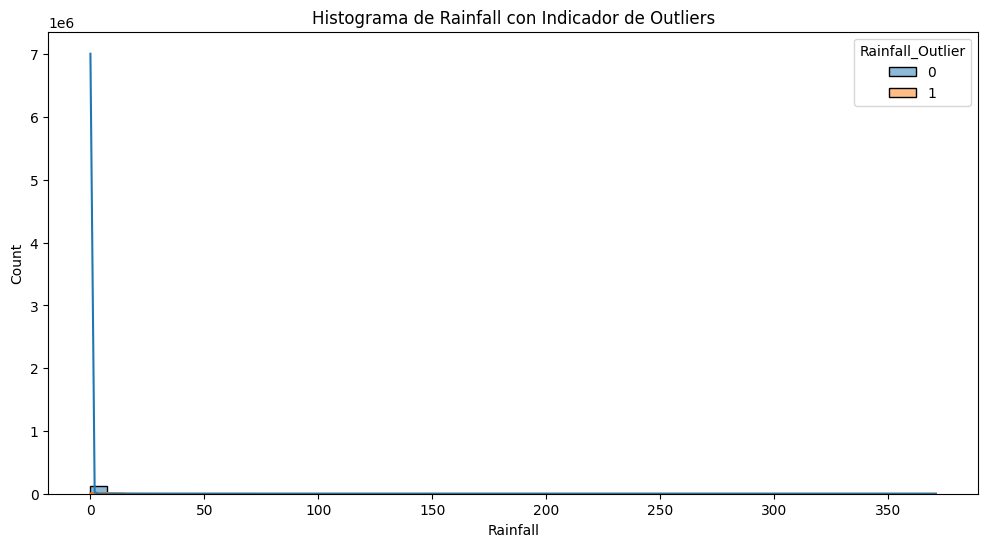

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Rainfall', hue='Rainfall_Outlier', bins=50, kde=True)
plt.title("Histograma de Rainfall con Indicador de Outliers")
plt.show()


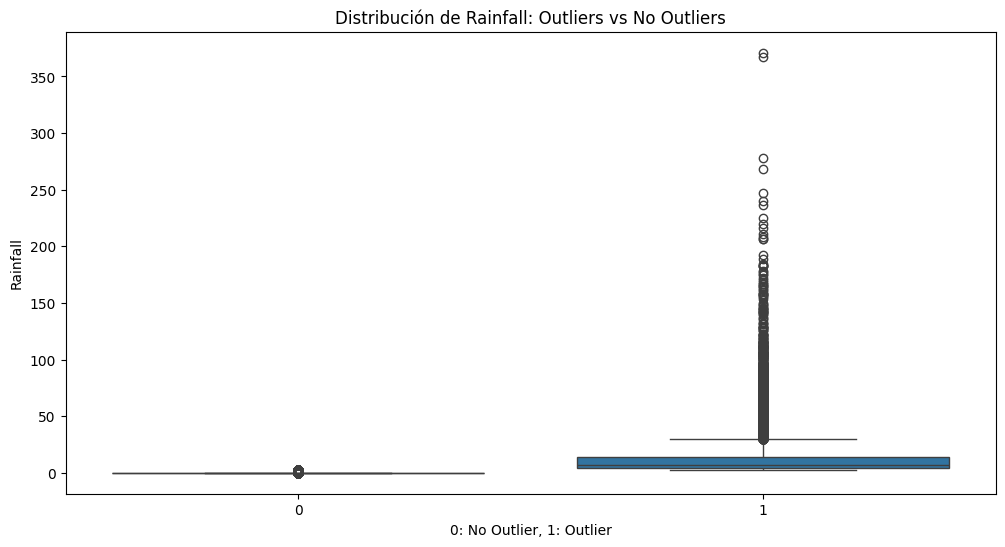

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rainfall_Outlier', y='Rainfall', data=df)
plt.title("Distribución de Rainfall: Outliers vs No Outliers")
plt.xlabel("0: No Outlier, 1: Outlier")
plt.show()


## ¿Por qué mantener la variable *Rainfall* con los outliers intactos?

En un **Análisis de Riesgo Climático o Fenómenos Extremos**, los outliers representan eventos de lluvia intensa que pueden desencadenar inundaciones o afectaciones severas. Precisamente porque son eventos raros pero de gran impacto, es fundamental conservarlos en la variable:

1. **Capturan la realidad de los fenómenos extremos:**  
   - Las lluvias torrenciales, aunque infrecuentes, son las que más riesgo generan. Eliminar o modificar estos valores puede subestimar la verdadera magnitud de las precipitaciones.

2. **Permiten identificar patrones de riesgo:**  
   - Analizar dónde y cuándo ocurren estos valores extremos (por ciudad, año o estación) facilita la detección de regiones y periodos con alta probabilidad de inundaciones.

3. **Mantienen la interpretabilidad:**  
   - Conservar *Rainfall* en milímetros permite comunicar de forma directa cuánta precipitación se registra, sin perder la referencia real de lo que significan esos valores.

4. **Son críticos para la construcción de índices de riesgo:**  
   - En un índice de riesgo climático, las variables que miden fenómenos extremos (como *Rainfall*) deben reflejar fielmente su impacto. Suavizar o eliminar estos valores podría ocultar los verdaderos eventos de mayor peligro.

# Extracción de Características Temporales

Una vez que hemos preparado y limpiado nuestros datos, el siguiente paso es extraer información temporal de la columna **Date**. Esto es fundamental para detectar patrones estacionales, tendencias a lo largo del tiempo y posibles eventos cíclicos que afectan el clima.

In [27]:
# Extraer características básicas de la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0 = lunes, 6 = domingo
df['Quarter'] = df['Date'].dt.quarter

# Función para asignar la estación (season) en base al mes, considerando el calendario australiano
def get_season(month):
    if month in [12, 1, 2]:
        return 'Verano'
    elif month in [3, 4, 5]:
        return 'Otoño'
    elif month in [6, 7, 8]:
        return 'Invierno'
    else:  # 9, 10, 11
        return 'Primavera'

# Aplicar la función para crear una nueva columna 'Season'
df['Season'] = df['Month'].apply(get_season)

# Visualizar las primeras filas para confirmar la extracción
print(df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Season']].head())

        Date  Year  Month  Day  DayOfWeek  Quarter  Season
0 2008-12-01  2008     12    1          0        4  Verano
1 2008-12-02  2008     12    2          1        4  Verano
2 2008-12-03  2008     12    3          2        4  Verano
3 2008-12-04  2008     12    4          3        4  Verano
4 2008-12-05  2008     12    5          4        4  Verano


## Importancia de la Extracción de Características Temporales

- **Detección de Tendencias y Estacionalidades:**  
  Permite identificar patrones recurrentes y ciclos estacionales, fundamentales para comprender el comportamiento climático.

- **Análisis de Eventos Extremos:**  
  Facilita segmentar el análisis por estaciones o trimestres, ayudando a determinar si ciertos periodos presentan mayor riesgo de fenómenos extremos.

- **Soporte para Modelado Predictivo:**  
  Las características temporales mejoran la precisión de los modelos al capturar variaciones cíclicas en el clima.

- **Segmentación Geográfica y Temporal:**  
  Combinado con la variable *Location*, posibilita análisis comparativos por región y la detección de períodos críticos para eventos extremos.


## Análisis de Patrones Temporales y Geográficos

### 1. Análisis por Estación y Mes


Promedio de Rainfall por Estación:
Season
Invierno     2.337699
Otoño        2.366780
Primavera    1.917052
Verano       2.782183
Name: Rainfall, dtype: float64


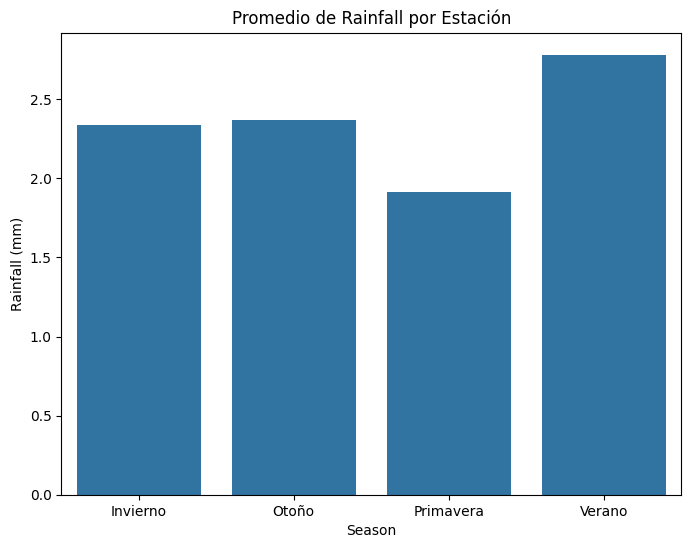

In [28]:
# Calcular el promedio de Rainfall por estación
season_rainfall = df.groupby('Season')['Rainfall'].mean()
print("Promedio de Rainfall por Estación:")
print(season_rainfall)

# Visualización con un barplot
plt.figure(figsize=(8,6))
sns.barplot(x=season_rainfall.index, y=season_rainfall.values)
plt.title("Promedio de Rainfall por Estación")
plt.ylabel("Rainfall (mm)")
plt.show()

### Distribución de Rainfall por Mes

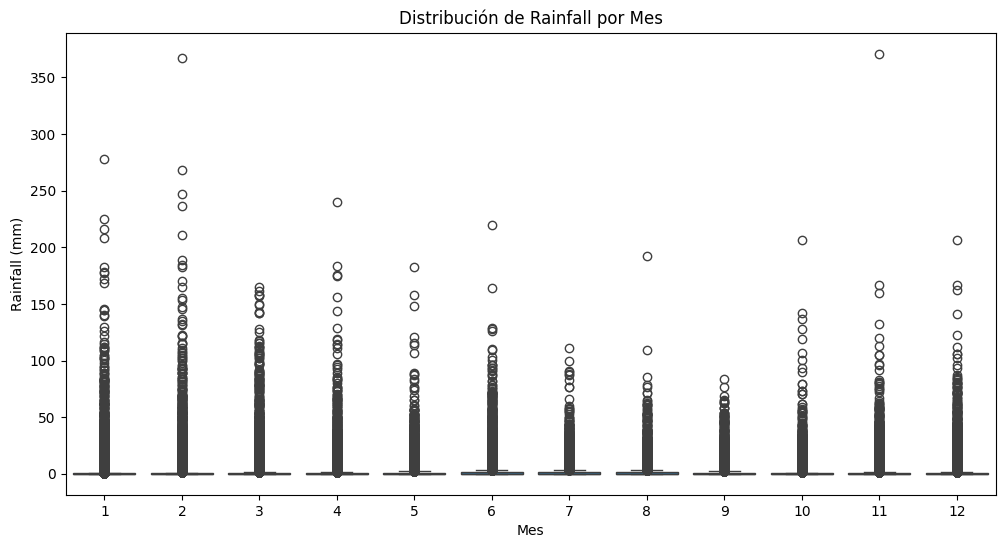

In [29]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Rainfall', data=df)
plt.title("Distribución de Rainfall por Mes")
plt.xlabel("Mes")
plt.ylabel("Rainfall (mm)")
plt.show()

## Análisis de Tendencias a lo Largo del Tiempo

### Evolución de MaxTemp a lo largo de los Años
Agrupa por el año para analizar cómo ha evolucionado la temperatura máxima con el tiempo. Esto puede ayudar a identificar tendencias o anomalías en el clima.

Promedio de MaxTemp por Año:
Year
2007    25.086885
2008    22.915316
2009    23.267068
2010    22.611432
2011    22.556836
2012    22.360729
2013    23.307716
2014    23.780649
2015    23.503581
2016    23.352724
2017    25.006532
Name: MaxTemp, dtype: float64


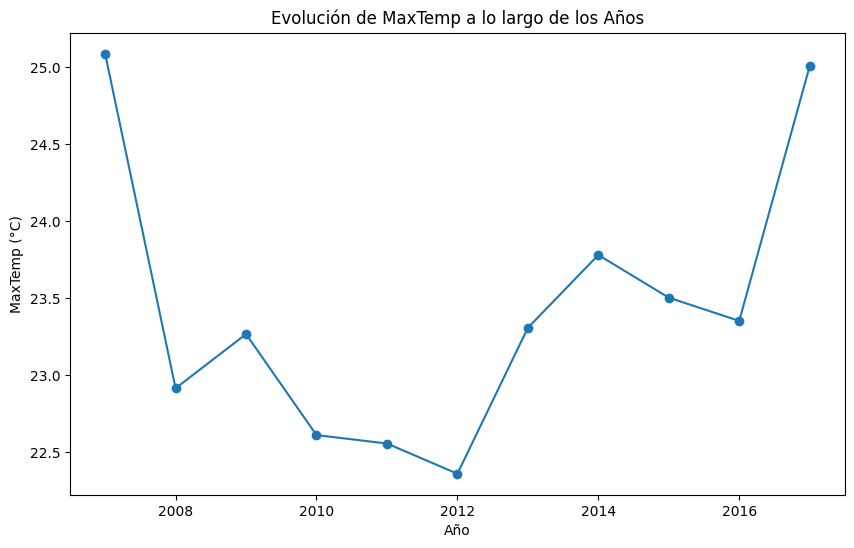

In [30]:
# Calcular el promedio de MaxTemp por año
year_maxTemp = df.groupby('Year')['MaxTemp'].mean()
print("Promedio de MaxTemp por Año:")
print(year_maxTemp)

# Gráfico de línea para visualizar la evolución de MaxTemp
plt.figure(figsize=(10,6))
year_maxTemp.plot(marker='o')
plt.title("Evolución de MaxTemp a lo largo de los Años")
plt.xlabel("Año")
plt.ylabel("MaxTemp (°C)")
plt.show()

## Análisis Combinado: Ubicación y Temporalidad

### Outliers y Promedios por Ubicación y Estación
Puedes combinar la información de ubicación y temporal para identificar qué regiones presentan fenómenos extremos en determinadas estaciones.

Promedio de Rainfall por Location y Season:
Season         Invierno     Otoño  Primavera    Verano
Location                                              
Adelaide       2.556193  1.627688   1.132653  0.949517
Albany         3.847020  1.920206   2.343466  0.890095
Albury         2.153501  1.919388   1.942736  1.683401
AliceSprings   0.359211  0.681715   0.530220  1.922312
BadgerysCreek  1.846785  2.615645   1.695726  2.667061


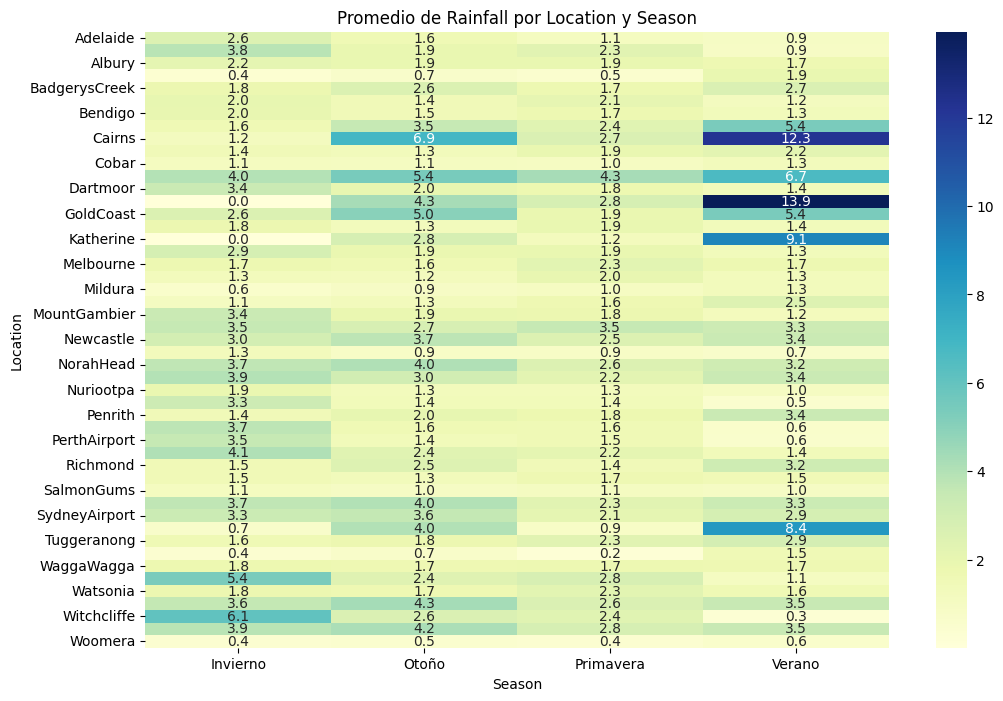

In [31]:
# Promedio de Rainfall por Location y Season
location_season = df.groupby(['Location', 'Season'])['Rainfall'].mean().unstack()
print("Promedio de Rainfall por Location y Season:")
print(location_season.head())

# Visualización de un heatmap para ver diferencias entre ciudades y estaciones
plt.figure(figsize=(12,8))
sns.heatmap(location_season, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title("Promedio de Rainfall por Location y Season")
plt.xlabel("Season")
plt.ylabel("Location")
plt.show()

# Análisis e Interpretación de Patrones Temporales y Geográficos

## 1. Rainfall por Estación y por Mes

1. **Promedio de Rainfall por Estación**  
   - El gráfico de barras muestra que **Verano** registra, en promedio, la mayor cantidad de lluvia, seguido de **Primavera** y **Otoño**, mientras que **Invierno** presenta los valores más bajos.  
   - Esto podría indicar un patrón estacional donde los meses de verano concentran mayor riesgo de lluvias intensas (especialmente en zonas tropicales o costeras).

2. **Distribución de Rainfall por Mes**  
   - El boxplot revela que la variable *Rainfall* es muy asimétrica en todos los meses, con numerosos outliers (episodios de lluvia intensa).  
   - Aunque cada mes tiene valores altos ocasionales, se observa que ciertos meses (por ejemplo, en el rango de noviembre a marzo) podrían presentar una mayor frecuencia de lluvias considerables, dependiendo de la región.

**Implicación para el Riesgo Climático:**  
- Al saber en qué estación o mes se concentran las precipitaciones más fuertes, puedes identificar períodos con mayor probabilidad de inundaciones o afectaciones en agricultura, logística, etc.

---

## 2. Evolución de MaxTemp a lo Largo de los Años

1. **Tendencia General**  
   - El gráfico de líneas muestra fluctuaciones de la temperatura máxima promedio entre 2008 y 2017, con valores que oscilan aproximadamente entre 22 °C y 25.2 °C.  
   - El año **2016** destaca por ser uno de los más cálidos dentro del periodo analizado, mientras que **2012** presenta uno de los promedios más bajos.

2. **Variabilidad Interanual**  
   - No se observa una tendencia claramente creciente o decreciente de manera constante; más bien, hay **variaciones anuales** que podrían atribuirse a factores climáticos globales (El Niño, La Niña) o regionales.

**Implicación para el Riesgo Climático:**  
- Conocer los años más cálidos permite identificar posibles olas de calor que afecten la salud pública, la demanda energética (por ejemplo, uso de aire acondicionado) o el estrés hídrico en la agricultura.

---

## 3. Análisis Combinado: Ubicación y Estación (Heatmap)

1. **Patrones Regionales y Estacionales**  
   - El heatmap muestra cómo varía el promedio de *Rainfall* según la **ciudad (Location)** y la **estación (Season)**.  
   - Algunas ciudades costeras o tropicales (p. ej., **Darwin, Cairns**) presentan promedios de lluvia mucho más elevados en ciertas estaciones (probablemente verano), mientras que zonas más templadas o áridas (p. ej., **AliceSprings, Woomera**) registran valores menores.

2. **Identificación de Zonas Críticas**  
   - Ciudades con colores más intensos (valores altos) en una o varias estaciones podrían considerarse zonas de **mayor riesgo de eventos extremos** (inundaciones o tormentas).

**Implicación para el Riesgo Climático:**  
- Combinar información temporal (estación) con la localización geográfica es clave para **priorizar** medidas preventivas en las zonas y temporadas donde las lluvias son más frecuentes o intensas.
